# Brain Tumor Detection from MRI — Custom CNN + Transfer Learning

**Dataset path is already set for your system.**  
This notebook trains two models:
- **Model A:** Custom CNN (baseline)
- **Model B:** Transfer Learning (EfficientNetB0, fallback to ResNet50)

It includes:
- EDA (samples, class balance, size stats)
- Preprocessing & augmentation
- Training & evaluation (Accuracy, Precision, Recall, F1, ROC-AUC)
- Confusion Matrix & ROC curves
- Correct vs Incorrect examples


## 0) Setup & Paths (pre-filled)

If you moved your dataset, change the `DATA_DIR` below to the new location.


In [ ]:


import os, glob, random, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_fscore_support)

print("TensorFlow:", tf.__version__)

# ---- YOUR DATASET PATH (already set) ----
DATA_DIR = Path("C:/Users/SREENIVAS SHANKAR /Downloads/Brain Tumor")  # <--- change only if you moved the folder
TRAIN_DIR = DATA_DIR / "Training"
TEST_DIR  = DATA_DIR / "Testing"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 16      # set 16 to be safe on laptops; increase to 32 if you have RAM
SEED       = 42

random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("Exists?",
      "DATA:", DATA_DIR.exists(),
      "TRAIN:", TRAIN_DIR.exists(),
      "TEST:", TEST_DIR.exists())


TensorFlow: 2.20.0
Exists? DATA: True TRAIN: True TEST: True


## 1) EDA — class counts, sample images, dimensions

Train samples: 203 Counter({'yes': 124, 'no': 79})
Test  samples: 50 Counter({'yes': 31, 'no': 19})


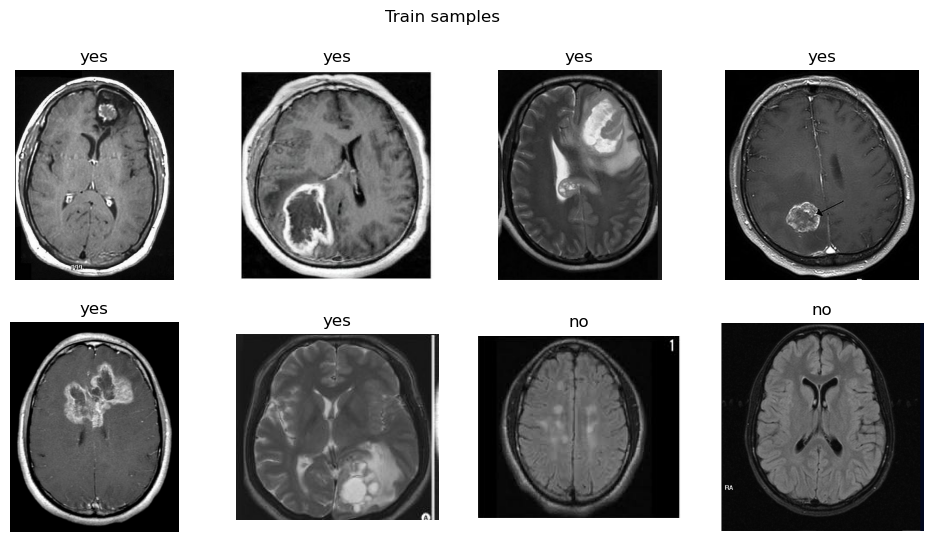

Average WxH over sample: [351.38 401.64]


In [3]:
import cv2
from collections import Counter

def list_images_in_class(root_dir):
    classes, paths = [], []
    for label in ["yes","no"]:
        cls_dir = Path(root_dir) / label
        imgs = sorted(glob.glob(str(cls_dir / "*")))
        classes.extend([label]*len(imgs))
        paths.extend(imgs)
    return paths, classes

train_paths, train_classes = list_images_in_class(TRAIN_DIR)
test_paths,  test_classes  = list_images_in_class(TEST_DIR)

print("Train samples:", len(train_paths), Counter(train_classes))
print("Test  samples:", len(test_paths), Counter(test_classes))

def show_samples(paths, classes, n=8, title="Samples"):
    if len(paths)==0:
        print("No images found. Check DATA_DIR/Training structure.")
        return
    plt.figure(figsize=(12,6))
    idxs = np.random.choice(len(paths), size=min(n, len(paths)), replace=False)
    for i, idx in enumerate(idxs, 1):
        img = cv2.imread(paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i)
        plt.imshow(img); plt.axis("off"); plt.title(classes[idx])
    plt.suptitle(title); plt.show()

show_samples(train_paths, train_classes, n=8, title="Train samples")

# Image size stats on a subset
dims = []
for p in train_paths[:100]:
    img = cv2.imread(p)
    if img is None: continue
    h, w = img.shape[:2]
    dims.append((w, h))
if dims:
    print("Average WxH over sample:", np.mean(dims, axis=0))
else:
    print("No images to compute dims — check path.")


## 2) Preprocessing & Augmentation

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='int', color_mode='rgb',
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True, seed=SEED
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    TEST_DIR, labels='inferred', label_mode='int', color_mode='rgb',
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)

# Split validation from train
val_fraction = 0.2
train_batches = int(len(train_ds) * (1 - val_fraction))
train_ds_shuf = train_ds.shuffle(1000, seed=SEED)
train_ds_final = train_ds_shuf.take(train_batches)
val_ds = train_ds_shuf.skip(train_batches)

def cfg(ds): return ds.cache().prefetch(AUTOTUNE)
train_ds_final, val_ds, test_ds = map(cfg, [train_ds_final, val_ds, test_ds])

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation")

rescale = layers.Rescaling(1./255)


Found 203 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Class names: ['no', 'yes']


## 3) Model A — Custom CNN (baseline)

In [5]:
def make_custom_cnn(input_shape=(224,224,3), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = rescale(x)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128,3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256,3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs, name="custom_cnn")

modelA = make_custom_cnn(input_shape=IMG_SIZE + (3,), num_classes=2)
modelA.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])
modelA.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")]
histA = modelA.fit(train_ds_final, validation_data=val_ds, epochs=25, callbacks=callbacks)


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,570 (1.61 MB)

 Trainable params: 421,570 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6129 - loss: 0.6738 - val_accuracy: 0.6250 - val_loss: 0.6607
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6129 - loss: 0.6619 - val_accuracy: 0.6250 - val_loss: 0.6315
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6129 - loss: 0.6534 - val_accuracy: 0.6250 - val_loss: 0.6237
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6129 - loss: 0.6430 - val_accuracy: 0.6250 - val_loss: 0.6254
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6129 - loss: 0.6483 - val_accuracy: 0.6250 - val_loss: 0.6159
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6129 - loss: 0.6394 - val_accuracy: 0.6250 - val_loss: 0.6158
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6129 - loss: 0.6381 - val_accuracy: 0.6458 - val_loss: 0.6087
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6129 - loss: 0.6336 - val_accuracy: 0.6458 - val_loss:

## 4) Model B — Transfer Learning (EfficientNetB0 → fallback ResNet50)

In [6]:
try:
    base = keras.applications.EfficientNetB0(include_top=False, input_shape=IMG_SIZE + (3,), weights="imagenet")
except Exception as e:
    print("EfficientNet not available, using ResNet50. Reason:", e)
    base = keras.applications.ResNet50(include_top=False, input_shape=IMG_SIZE + (3,), weights="imagenet")

base.trainable = False

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs); x = rescale(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation="softmax")(x)
modelB = keras.Model(inputs, outputs, name="transfer_model")

modelB.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])
modelB.summary()

callbacks2 = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")]
histB = modelB.fit(train_ds_final, validation_data=val_ds, epochs=15, callbacks=callbacks2)

# Fine-tune
base.trainable = True
modelB.compile(optimizer=keras.optimizers.Adam(1e-5),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])
histB_ft = modelB.fit(train_ds_final, validation_data=val_ds, epochs=10, callbacks=callbacks2)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 37s 2us/step


Model: "transfer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5935 - loss: 0.6871 - val_accuracy: 0.6250 - val_loss: 0.6701
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 956ms/step - accuracy: 0.5548 - loss: 0.6980 - val_accuracy: 0.6250 - val_loss: 0.6642
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 998ms/step - accuracy: 0.6129 - loss: 0.6727 - val_accuracy: 0.6250 - val_loss: 0.6638
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 988ms/step - accuracy: 0.6065 - loss: 0.6819 - val_accuracy: 0.6250 - val_loss: 0.6670
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5871 - loss: 0.6818 - val_accuracy: 0.6250 - val_loss: 0.6639
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5871 - loss: 0.6808 - val_accuracy: 0.6250 - val_loss: 0.6663
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6065 - loss: 0.6874 - val_accuracy: 0.6250 - val_loss: 0.6635
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 980ms/step - accuracy: 0.6258 - loss: 0.6706 - val_accuracy: 0.6250 

## 5) Evaluation — metrics + Confusion Matrix + ROC

Custom CNN — ACC: 0.6400, Precision: 0.6857, Recall: 0.7742, F1: 0.7273, AUC: 0.7046
              precision    recall  f1-score   support

    No Tumor       0.53      0.42      0.47        19
       Tumor       0.69      0.77      0.73        31

    accuracy                           0.64        50
   macro avg       0.61      0.60      0.60        50
weighted avg       0.63      0.64      0.63        50



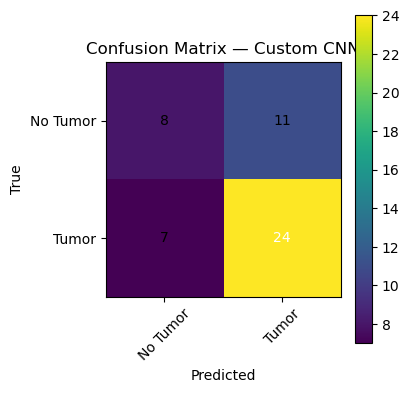

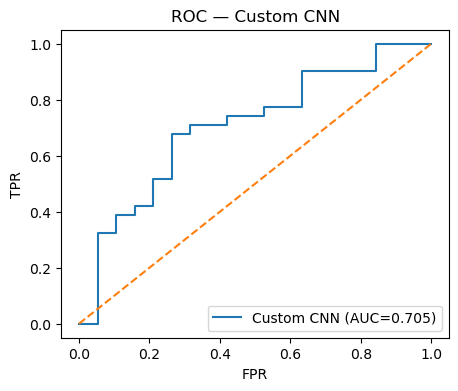

Transfer Model — ACC: 0.6200, Precision: 0.6200, Recall: 1.0000, F1: 0.7654, AUC: 0.5484
              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00        19
       Tumor       0.62      1.00      0.77        31

    accuracy                           0.62        50
   macro avg       0.31      0.50      0.38        50
weighted avg       0.38      0.62      0.47        50



C:\Users\anjin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anjin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\anjin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


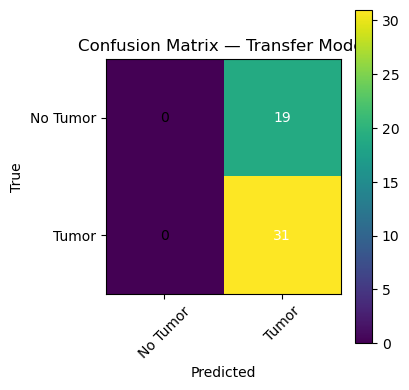

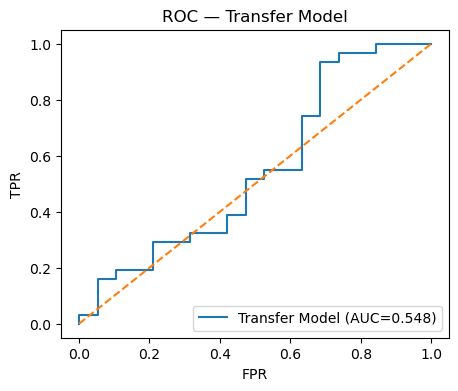

Saved metrics to metrics_summary.json


In [7]:
def evaluate_model(model, dataset, name="model"):
    y_true, y_prob = [], []
    for x, y in dataset:
        p = model.predict(x, verbose=0)
        y_prob.extend(p[:,1])
        y_true.extend(y.numpy())
    y_true = np.array(y_true); y_prob = np.array(y_prob)
    y_pred = (y_prob >= 0.5).astype(int)

    acc = np.mean(y_pred == y_true)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except:
        auc = float("nan")

    print(f"{name} — ACC: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_true, y_pred, target_names=['No Tumor','Tumor']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix — {name}'); plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['No Tumor','Tumor'], rotation=45)
    plt.yticks(ticks, ['No Tumor','Tumor'])
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha='center', va='center',
                     color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout(); plt.ylabel('True'); plt.xlabel('Predicted'); plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})"); plt.plot([0,1],[0,1],'--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC — {name}'); plt.legend(loc='lower right'); plt.show()

    return {"acc":acc, "precision":precision, "recall":recall, "f1":f1, "auc":auc}

metricsA = evaluate_model(modelA, test_ds, name="Custom CNN")
metricsB = evaluate_model(modelB, test_ds, name="Transfer Model")

import json
with open("metrics_summary.json","w") as f:
    json.dump({"Custom_CNN":metricsA,"Transfer_Model":metricsB}, f, indent=2)
print("Saved metrics to metrics_summary.json")


## 6) Qualitative — Correct vs Incorrect predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.4375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


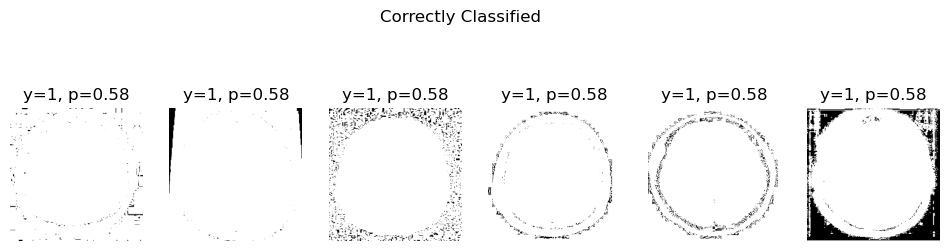

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.87126].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.20213].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.37163].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..251.92139].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..251.64062].


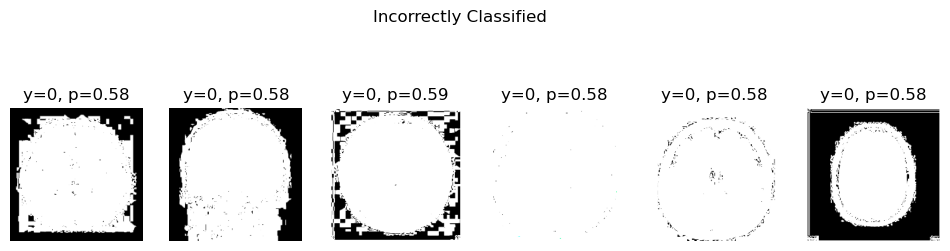

In [8]:
def show_predictions(model, dataset, n=12):
    imgs, labels, probs = [], [], []
    for x, y in dataset.unbatch().take(200):
        x_np = x.numpy()
        p = model.predict(tf.expand_dims(x,0), verbose=0)[0]
        imgs.append(x_np); labels.append(int(y.numpy())); probs.append(float(p[1]))
    preds = (np.array(probs)>=0.5).astype(int)

    correct = np.where(preds == np.array(labels))[0][:n//2]
    wrong   = np.where(preds != np.array(labels))[0][:n//2]

    def plot_subset(idxs, title):
        if len(idxs)==0: 
            print("No samples to show."); return
        plt.figure(figsize=(12,6))
        for i, idx in enumerate(idxs[:min(len(idxs), n)]):
            plt.subplot(2, n//2, i+1)
            plt.imshow(imgs[idx]); plt.axis('off'); plt.title(f"y={labels[idx]}, p={probs[idx]:.2f}")
        plt.suptitle(title); plt.show()

    plot_subset(correct, "Correctly Classified")
    plot_subset(wrong,   "Incorrectly Classified")

show_predictions(modelB, test_ds, n=12)
